Analyse how our approximation

\begin{equation}
    \text{tr} \left( K^{-1} \frac{dK}{d\theta} \right) \approx \frac{1}{S} \sum_{i=1}^S z_i^T C^{-1} \frac{dK}{d\theta} z_i; \quad z_i \sim N(0, I)
\end{equation}
changes for a 1D problem, as we vary $\theta$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lazy_GP import GP
%matplotlib inline
gp = GP()

Generate some input data (we don't need targets for this analysis)

In [2]:
np.random.seed(42)
N = 100
D = 1
X = np.vstack(np.linspace(0, 10, N))
sigma = 0.1
y = np.sin(X) + sigma * np.random.randn(N, 1)

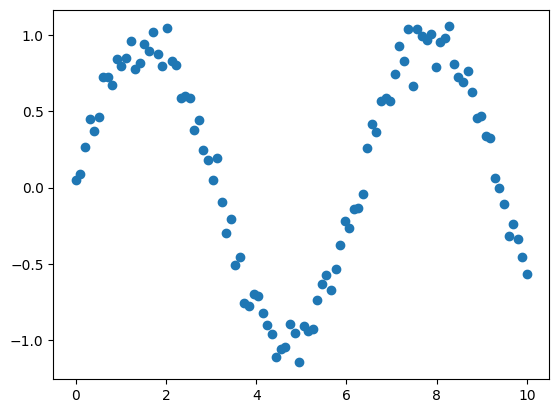

In [3]:
fig, ax = plt.subplots()
ax.plot(X, y, 'o')
plt.show()

Long-winded way of finding $K$, $C^{-1}$ and $dK/d\theta_{d'}$ to compute $\text{Tr}(C^{-1} dK/d\theta)$

In [4]:
def dlogp_exact(X, y, theta, sigma, d_dash):
    N, D = np.shape(X)
    K = np.ones([N, N])
    dK_dtheta = np.zeros([N, N])
    for i in range(N):
        for j in range(N):
            dK_dtheta[i, j] = theta[d_dash]**-3
            for d in range(D):
                K[i, j] *= np.exp(-0.5 * (X[i, d] - X[j, d])**2)
                dK_dtheta[i, j] *= np.exp(-0.5 * (X[i, d] - X[j, d])**2)
            dK_dtheta[i, j] *= (X[i, d_dash] - X[j, d_dash])**2
    C = K + np.eye(N) * sigma**2
    inv_C = np.linalg.inv(C)
    alpha = inv_C @ y
    g = 0.5 * alpha.T @ dK_dtheta @ alpha
    g = g - 0.5 * np.trace(inv_C @ dK_dtheta)
    return g[0]

Compare long-winded exact approach with approximation approach for different $\theta$

In [13]:
theta_ar = np.linspace(0.2, 1, 50)
d_dash = [0]
term = []
term_exact = []
S = 10
for theta in theta_ar:
    term.append(gp.dlogp(X=X, y=y, theta=np.array([theta]), sigma=sigma, d_dash=d_dash, tol=1e-3))
    term_exact.append(dlogp_exact(X, y=y, theta=np.array([theta]), sigma=sigma, d_dash=d_dash))

/tmp/ipykernel_33364/3388823728.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dK_dtheta[i, j] = theta[d_dash]**-3
/tmp/ipykernel_33364/3388823728.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dK_dtheta[i, j] *= (X[i, d_dash] - X[j, d_dash])**2


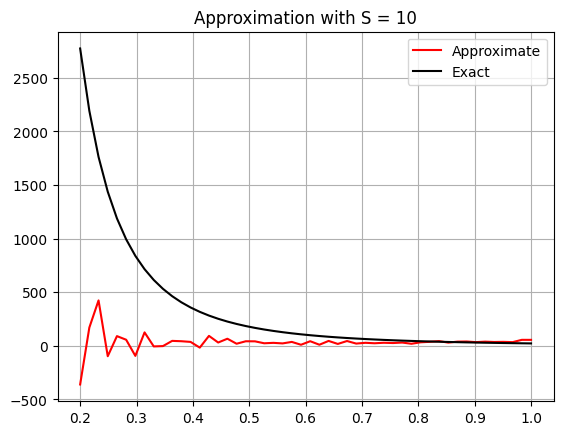

In [14]:
fig, ax = plt.subplots()
ax.set_title("Approximation with S = " + str(S))
ax.plot(theta_ar, term, color='red', label='Approximate')
ax.plot(theta_ar, term_exact, color='black', label='Exact')
ax.grid()
ax.legend()
plt.show()